<a href="https://colab.research.google.com/github/alvlagus/Introduction_to_NLP_GB/blob/Lesson_8/gusev_NLP_HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'>Введение в обработку естественного языка</h1>  

<h2 align='center'>Урок 8. Рекуррентные нейронные сети RNN LSTM GRU</h2>  

<h3 align='left'>Практическое задание:</h3>  

Данные берем отызывы за лето

На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи

1. построить свёрточные архитектуры

2. построить различные архитектуры с RNN

3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)

###Загружаем библиотеки:

In [ ]:
!pip install -qq stop_words
!pip install -qq pymorphy2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 59.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from collections import Counter

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.callbacks import EarlyStopping  

import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###Загружаем данные:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/25_NLP/work_7/data/отзывы за лето.xls')
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Rating', axis=1), df['Rating'], test_size=0.2, random_state=42, shuffle=True)
X_train.head()

,Content,Date
2680,Очень удобно!!!,2017-08-10
844,Не приходит смс код для входа в приложение,2017-08-12
18714,Пока все удобно и понятно.,2017-07-01
13842,Удобное приложение. Работает отлично.,2017-07-24
11974,Очень удобное приложение!!,2017-07-28


In [ ]:
y_train.value_counts()

5    11654
1     1822
4     1735
3      724
2      592
Name: Rating, dtype: int64

In [ ]:
disbalance = (y_train.value_counts().sort_index().max()/y_train.value_counts().sort_index()).values
disbalance

array([ 6.39626784, 19.68581081, 16.09668508,  6.71700288,  1.        ])

### Предобработка

In [ ]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in nltk.word_tokenize(txt) if word not in sw]   
    return " ".join(txt)

X_train['Content_preprocess'] = X_train['Content'].apply(preprocess_text)
X_test['Content_preprocess'] = X_test['Content'].apply(preprocess_text)
X_train.head()

,Content,Date,Content_preprocess
2680,Очень удобно!!!,2017-08-10,удобно
844,Не приходит смс код для входа в приложение,2017-08-12,приходить смс код вход приложение
18714,Пока все удобно и понятно.,2017-07-01,удобно понятно
13842,Удобное приложение. Работает отлично.,2017-07-24,удобный приложение работать отлично
11974,Очень удобное приложение!!,2017-07-28,удобный приложение


In [ ]:
corpus = (" ".join(X_train['Content_preprocess'])).split()
corpus_count = Counter(corpus)
corpus_count.most_common(10)

[('приложение', 4936),
 ('удобно', 2606),
 ('работать', 1550),
 ('удобный', 1413),
 ('отлично', 1034),
 ('нравиться', 899),
 ('отличный', 821),
 ('хороший', 809),
 ('телефон', 754),
 ('супер', 660)]

In [ ]:
max_words_true = len(corpus_count)
max_words_true

11524

In [ ]:
MAX_WORDS = 5000
MAX_WORDS

11524

In [ ]:
vocabulary = {j:i for i, (j, _) in enumerate(corpus_count.most_common()[:MAX_WORDS], 1)}
list(vocabulary.items())[:10]

[('приложение', 1),
 ('удобно', 2),
 ('работать', 3),
 ('удобный', 4),
 ('отлично', 5),
 ('нравиться', 6),
 ('отличный', 7),
 ('хороший', 8),
 ('телефон', 9),
 ('супер', 10)]

In [ ]:
max_len_true = max([len(txt) for txt in X_train['Content_preprocess']])
max_len_true

907

In [ ]:
np.mean([len(txt) for txt in X_train['Content_preprocess']])

41.75010588733588

In [ ]:
MAX_LEN = 200
MAX_LEN

907

In [ ]:
X_train['Content_sequence'] = X_train['Content_preprocess'].apply(lambda text: [vocabulary.get(word, 0) for word in text.split()][:MAX_LEN]+[0]*(MAX_LEN-len(text.split())))
X_test['Content_sequence'] = X_test['Content_preprocess'].apply(lambda text: [vocabulary.get(word, 0) for word in text.split()][:MAX_LEN]+[0]*(MAX_LEN-len(text.split())))
X_train.head()

,Content,Date,Content_preprocess,Content_sequence
2680,Очень удобно!!!,2017-08-10,удобно,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
844,Не приходит смс код для входа в приложение,2017-08-12,приходить смс код вход приложение,"[57, 45, 42, 18, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
18714,Пока все удобно и понятно.,2017-07-01,удобно понятно,"[2, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
13842,Удобное приложение. Работает отлично.,2017-07-24,удобный приложение работать отлично,"[4, 1, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11974,Очень удобное приложение!!,2017-07-28,удобный приложение,"[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
X_train_array = np.array([[j for j in i] for i in X_train['Content_sequence']])
X_test_array = np.array([[j for j in i] for i in X_test['Content_sequence']])
X_train_array[0][:10]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_train_array = y_train-1
y_test_array = y_test-1
y_train_array.head()

2680     4
844      1
18714    3
13842    4
11974    4
Name: Rating, dtype: int64

In [ ]:
dict_metrics = {}

## 1. построить свёрточные архитектуры

In [ ]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle('Horizontally stacked subplots')
       
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='upper left')

In [ ]:
embedding_dim = 300
hidden_dim = 512
EPOCH_NUM = 3

###CNN

In [ ]:
model = Sequential([
    Embedding(MAX_WORDS+1, embedding_dim, mask_zero=True),
    Conv1D(embedding_dim*2, 3),
    GlobalMaxPool1D(),
    Dense(hidden_dim, activation='relu'),
    Dense(hidden_dim//2, activation='relu'),

    Dense(units=5, activation='sigmoid')
])

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss_weights=disbalance,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3457500   
                                                                 
 conv1d (Conv1D)             (None, None, 600)         540600    
                                                                 
 global_max_pooling1d (Globa  (None, 600)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 512)               307712    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                        

In [ ]:
%%time
history = model.fit(X_train_array, y_train_array, validation_data=(X_test_array, y_test_array), epochs=EPOCH_NUM)

Epoch 1/5
517/517 [==============================] - 62s 96ms/step - loss: 6.8928 - accuracy: 0.7618 - val_loss: 6.5195 - val_accuracy: 0.7769
Epoch 2/5
517/517 [==============================] - 27s 52ms/step - loss: 5.4240 - accuracy: 0.8089 - val_loss: 6.9106 - val_accuracy: 0.7679
Epoch 3/5
517/517 [==============================] - 28s 54ms/step - loss: 4.1414 - accuracy: 0.8568 - val_loss: 7.3357 - val_accuracy: 0.7679
Epoch 4/5
517/517 [==============================] - 25s 48ms/step - loss: 3.2676 - accuracy: 0.8864 - val_loss: 7.9780 - val_accuracy: 0.7592
Epoch 5/5
517/517 [==============================] - 25s 48ms/step - loss: 2.5513 - accuracy: 0.9155 - val_loss: 10.0022 - val_accuracy: 0.7502


In [ ]:
print(classification_report(np.argmax(model.predict(X_test_array), axis=1), y_test_array))

130/130 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       427
           1       0.14      0.16      0.15       140
           2       0.12      0.20      0.15       114
           3       0.18      0.26      0.21       280
           4       0.93      0.86      0.90      3171

    accuracy                           0.75      4132
   macro avg       0.39      0.41      0.40      4132
weighted avg       0.79      0.75      0.77      4132



In [ ]:
score_cnn = model.evaluate(X_test_array, y_test_array)
score_cnn

130/130 [==============================] - 2s 13ms/step - loss: 10.0022 - accuracy: 0.7502


[10.002214431762695, 0.7502419948577881]

In [ ]:
dict_metrics['CNN'] = score_cnn[1]

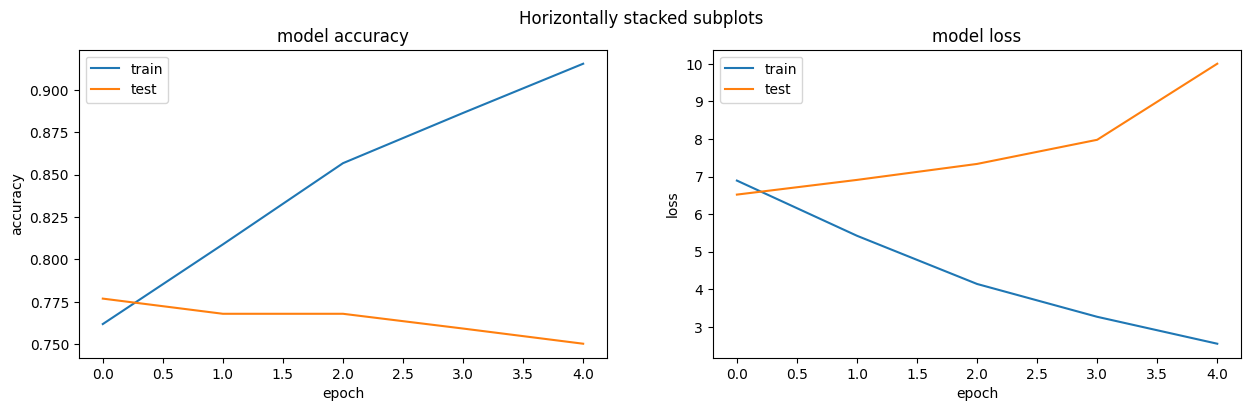

In [ ]:
plot_history(history)

## 2. построить различные архитектуры с RNN

###RNN

In [ ]:
model = Sequential()

model.add(
    Embedding(input_dim=MAX_WORDS + 1,
              input_length=MAX_LEN,
              output_dim=embedding_dim,
              trainable=True,
              mask_zero=True))

model.add(SimpleRNN(hidden_dim))
model.add(Dense(hidden_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss_weights=disbalance,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 907, 300)          3457500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 512)               416256    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 4,138,977
Trainable params: 4,138,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(X_train_array, y_train_array, validation_data=(X_test_array, y_test_array), epochs=EPOCH_NUM)

Epoch 1/5
517/517 [==============================] - 755s 1s/step - loss: 10.0062 - accuracy: 0.7078 - val_loss: 9.7663 - val_accuracy: 0.7173
Epoch 2/5
517/517 [==============================] - 762s 1s/step - loss: 7.6789 - accuracy: 0.7430 - val_loss: 7.1383 - val_accuracy: 0.7626
Epoch 3/5
517/517 [==============================] - 744s 1s/step - loss: 6.9700 - accuracy: 0.7592 - val_loss: 8.5751 - val_accuracy: 0.7553
Epoch 4/5
517/517 [==============================] - 732s 1s/step - loss: 7.2032 - accuracy: 0.7531 - val_loss: 7.6484 - val_accuracy: 0.7435
Epoch 5/5
517/517 [==============================] - 737s 1s/step - loss: 6.6148 - accuracy: 0.7699 - val_loss: 7.5525 - val_accuracy: 0.7556
CPU times: user 1h 21min 59s, sys: 9min 3s, total: 1h 31min 3s
Wall time: 1h 2min 11s


In [ ]:
print(classification_report(np.argmax(model.predict(X_test_array), axis=1), y_test_array)) 

130/130 [==============================] - 14s 107ms/step
              precision    recall  f1-score   support

           0       0.84      0.41      0.55       943
           1       0.00      0.00      0.00         0
           2       0.02      0.17      0.03        18
           3       0.03      0.21      0.06        62
           4       0.93      0.88      0.90      3109

    accuracy                           0.76      4132
   macro avg       0.36      0.33      0.31      4132
weighted avg       0.89      0.76      0.80      4132



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
score_rnn = model.evaluate(X_test_array, y_test_array)
score_rnn

130/130 [==============================] - 14s 107ms/step - loss: 7.5525 - accuracy: 0.7556


[7.552460193634033, 0.7555662989616394]

In [ ]:
dict_metrics['RNN'] = score_rnn[1]

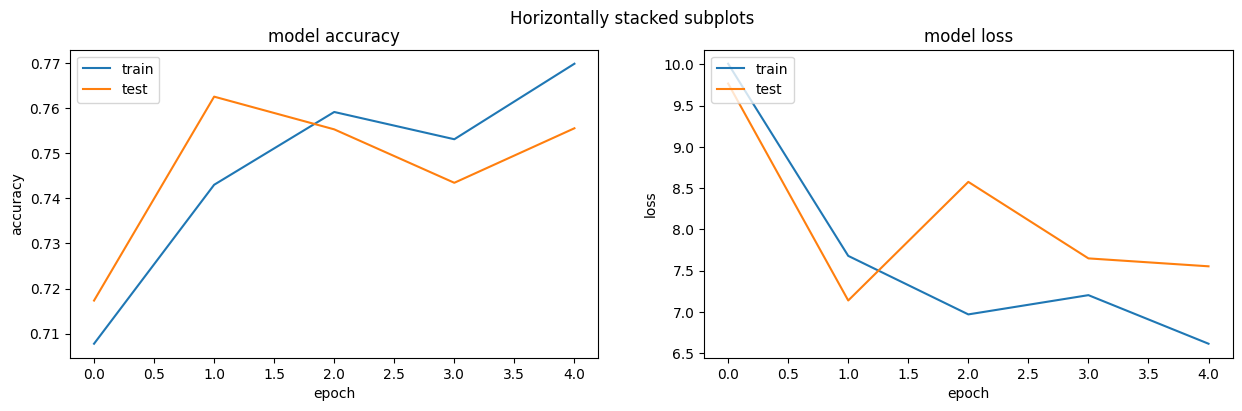

In [ ]:
plot_history(history)

###LSTM

In [ ]:
model = Sequential()

model.add(
    Embedding(input_dim=MAX_WORDS + 1,
              input_length=MAX_LEN,
              output_dim=embedding_dim,
              trainable=True,
              mask_zero=True))

model.add(LSTM(hidden_dim))
model.add(Dense(hidden_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss_weights=disbalance,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 907, 300)          3457500   
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 5,387,745
Trainable params: 5,387,745
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(X_train_array, y_train_array, validation_data=(X_test_array, y_test_array), epochs=EPOCH_NUM)

Epoch 1/5
517/517 [==============================] - 842s 2s/step - loss: 7.3119 - accuracy: 0.7560 - val_loss: 6.6623 - val_accuracy: 0.7718
Epoch 2/5
517/517 [==============================] - 819s 2s/step - loss: 5.5630 - accuracy: 0.8038 - val_loss: 7.1112 - val_accuracy: 0.7645
Epoch 3/5
517/517 [==============================] - 814s 2s/step - loss: 4.4042 - accuracy: 0.8487 - val_loss: 8.1252 - val_accuracy: 0.7522
Epoch 4/5
517/517 [==============================] - 826s 2s/step - loss: 3.4380 - accuracy: 0.8869 - val_loss: 8.5861 - val_accuracy: 0.7500
Epoch 5/5
517/517 [==============================] - 765s 1s/step - loss: 2.7335 - accuracy: 0.9116 - val_loss: 9.9462 - val_accuracy: 0.7541
CPU times: user 1h 27min 14s, sys: 10min 17s, total: 1h 37min 31s
Wall time: 1h 7min 46s


In [ ]:
print(classification_report(np.argmax(model.predict(X_test_array), axis=1), y_test_array))

130/130 [==============================] - 21s 153ms/step
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       529
           1       0.09      0.14      0.11       102
           2       0.12      0.17      0.14       135
           3       0.13      0.27      0.18       194
           4       0.93      0.86      0.90      3172

    accuracy                           0.75      4132
   macro avg       0.38      0.40      0.38      4132
weighted avg       0.81      0.75      0.78      4132



In [ ]:
score_lstm = model.evaluate(X_test_array, y_test_array)
score_lstm 

130/130 [==============================] - 21s 164ms/step - loss: 9.9462 - accuracy: 0.7541


[9.946194648742676, 0.7541142106056213]

In [ ]:
dict_metrics['LSTM'] = score_lstm[1]

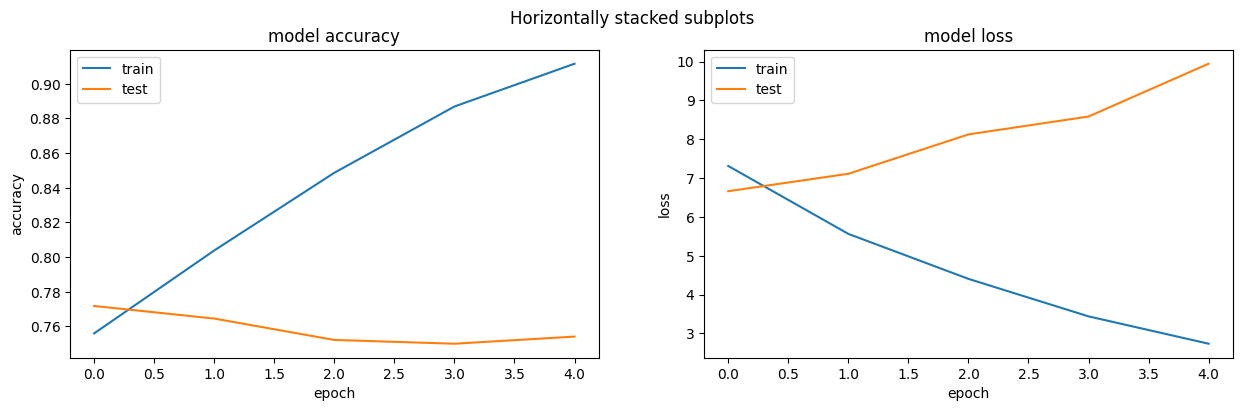

In [ ]:
plot_history(history)

###GRU

In [ ]:
model = Sequential()

model.add(
    Embedding(input_dim=MAX_WORDS + 1,
              input_length=MAX_LEN,
              output_dim=embedding_dim,
              trainable=True,
              mask_zero=True))

model.add(GRU(hidden_dim))
model.add(Dense(hidden_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss_weights=disbalance,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 907, 300)          3457500   
                                                                 
 gru (GRU)                   (None, 512)               1250304   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 4,973,025
Trainable params: 4,973,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(X_train_array, y_train_array, validation_data=(X_test_array, y_test_array), epochs=EPOCH_NUM)

Epoch 1/3
517/517 [==============================] - 884s 2s/step - loss: 7.2032 - accuracy: 0.7598 - val_loss: 6.5961 - val_accuracy: 0.7776
Epoch 2/3
517/517 [==============================] - 972s 2s/step - loss: 5.4702 - accuracy: 0.8060 - val_loss: 7.0098 - val_accuracy: 0.7679
Epoch 3/3
517/517 [==============================] - 864s 2s/step - loss: 4.2945 - accuracy: 0.8517 - val_loss: 7.8566 - val_accuracy: 0.7580
CPU times: user 56min 10s, sys: 6min 40s, total: 1h 2min 50s
Wall time: 45min 19s


In [ ]:
print(classification_report(np.argmax(model.predict(X_test_array), axis=1), y_test_array))

130/130 [==============================] - 26s 185ms/step
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       500
           1       0.12      0.14      0.13       140
           2       0.22      0.21      0.21       195
           3       0.13      0.34      0.19       154
           4       0.93      0.87      0.90      3143

    accuracy                           0.76      4132
   macro avg       0.41      0.42      0.40      4132
weighted avg       0.80      0.76      0.78      4132



In [ ]:
score_gru = model.evaluate(X_test_array, y_test_array)
score_gru

130/130 [==============================] - 25s 190ms/step - loss: 7.8566 - accuracy: 0.7580


[7.856577396392822, 0.7579864263534546]

In [ ]:
dict_metrics['GRU'] = score_gru[1]

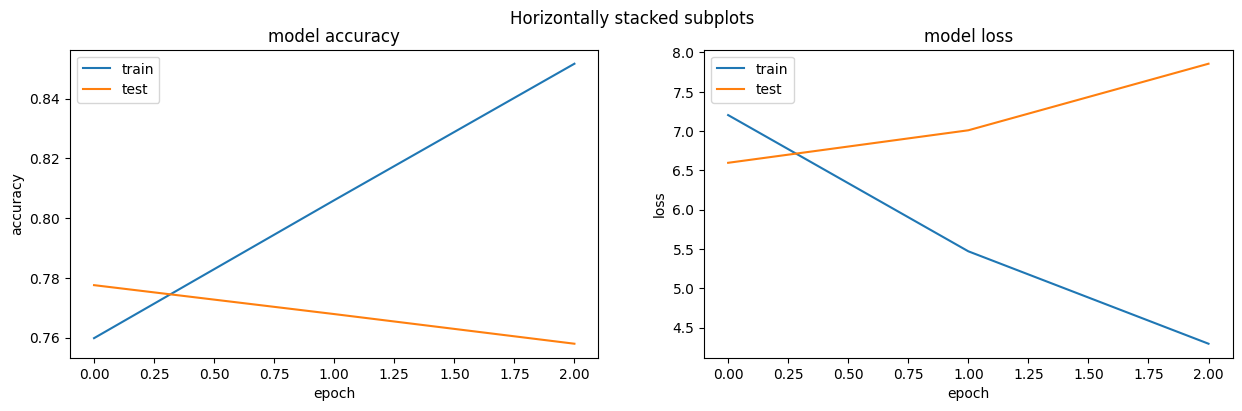

In [ ]:
plot_history(history)

## 3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)

###CNN_RNN

In [ ]:
model = Sequential([
    Embedding(MAX_WORDS+1, embedding_dim, mask_zero=True),
    Conv1D(embedding_dim*2, 3),
    LSTM(embedding_dim*2, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(hidden_dim, activation='relu'),
    Dense(hidden_dim//2, activation='relu'),

    Dense(units=5, activation='sigmoid')
])

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss_weights=disbalance,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3457500   
                                                                 
 conv1d (Conv1D)             (None, None, 600)         540600    
                                                                 
 lstm (LSTM)                 (None, None, 600)         2882400   
                                                                 
 global_max_pooling1d (Globa  (None, 600)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 512)               307712    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                      

In [ ]:
%%time
history = model.fit(X_train_array, y_train_array, validation_data=(X_test_array, y_test_array), epochs=EPOCH_NUM)

Epoch 1/3
517/517 [==============================] - 171s 315ms/step - loss: 7.0644 - accuracy: 0.7589 - val_loss: 6.7347 - val_accuracy: 0.7708
Epoch 2/3
517/517 [==============================] - 157s 304ms/step - loss: 5.7853 - accuracy: 0.7960 - val_loss: 6.9891 - val_accuracy: 0.7706
Epoch 3/3
517/517 [==============================] - 148s 286ms/step - loss: 4.8737 - accuracy: 0.8259 - val_loss: 7.3134 - val_accuracy: 0.7633


In [ ]:
print(classification_report(np.argmax(model.predict(X_test_array), axis=1), y_test_array))

130/130 [==============================] - 11s 85ms/step
              precision    recall  f1-score   support

           0       0.63      0.55      0.58       522
           1       0.05      0.19      0.08        43
           2       0.10      0.20      0.13        88
           3       0.25      0.27      0.26       376
           4       0.93      0.88      0.91      3103

    accuracy                           0.76      4132
   macro avg       0.39      0.42      0.39      4132
weighted avg       0.81      0.76      0.78      4132



In [ ]:
score_cnn_rnn = model.evaluate(X_test_array, y_test_array)
score_cnn_rnn

130/130 [==============================] - 12s 90ms/step - loss: 7.3134 - accuracy: 0.7633


[7.313426494598389, 0.7633107304573059]

In [ ]:
dict_metrics['CNN-RNN'] = score_cnn_rnn[1]

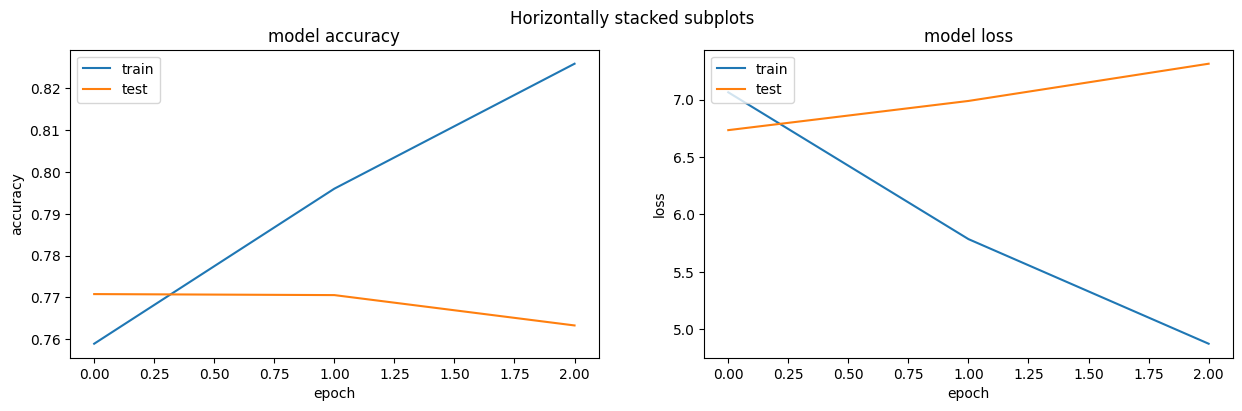

In [ ]:
plot_history(history)

###RNN_CNN

In [ ]:
model = Sequential([
    Embedding(MAX_WORDS+1, embedding_dim, mask_zero=True),
    LSTM(embedding_dim*2, return_sequences=True),
    Conv1D(embedding_dim*2, 3),    
    GlobalMaxPool1D(),
    Dense(hidden_dim, activation='relu'),
    Dense(hidden_dim//2, activation='relu'),

    Dense(units=5, activation='sigmoid')
])

model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              loss_weights=disbalance,
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         3457500   
                                                                 
 lstm_1 (LSTM)               (None, None, 600)         2162400   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 600)         1080600   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 600)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 512)               307712    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

In [ ]:
%%time
history = model.fit(X_train_array, y_train_array, validation_data=(X_test_array, y_test_array), epochs=EPOCH_NUM)

Epoch 1/3
 28/517 [>.............................] - ETA: 19:55 - loss: 9.6854 - accuracy: 0.7031

KeyboardInterrupt: ignored

In [ ]:
print(classification_report(np.argmax(model.predict(X_test_array), axis=1), y_test_array))

In [ ]:
score_rnn_cnn = model.evaluate(X_test_array, y_test_array)
score_rnn_cnn

In [ ]:
dict_metrics['RNN-CNN'] = score_rnn_cnn[1]

In [ ]:
plot_history(history)

##Вывод

In [ ]:
list(sorted(dict_metrics.items(), key=lambda x: -x[1]))

[('CNN-RNN', 0.7633107304573059), ('GRU', 0.7579864263534546)]